To begin copy this notebook to your own drive:

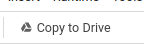


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:01<00:00, 260MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 151MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [5]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [6]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-7-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [44]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [76]:
from torch import nn
import torch
from torch.distributions.bernoulli import Bernoulli

#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, num_hidden_layers, dropout, activation):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          emd_dims = 300
          hidden_dims = 300
          # YOUR CODE HERE
          self.dropout = dropout
          model = []
          model.append(nn.Linear(emd_dims, hidden_dims))
          model.append(activation)
          for i in range(num_hidden_layers):
            model.append(nn.Linear(hidden_dims, hidden_dims))
            model.append(activation)
          model.append(nn.Linear(hidden_dims, self.num_labels))
          model.append(nn.Softmax(dim=1))
          self.classifier = nn.Sequential(*model)
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      masked_embs = input_ids * attention_masks
      x = self.embeddings(masked_embs)      
      rw = Bernoulli(1-self.dropout).sample((x.shape[1], ))
      x = x[:, rw==1]
      avg = torch.mean(x, 1) 
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res, labels)
      return {"loss":loss,"logits":res}



In [89]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()

def configure_model(num_train_epochs, num_hidden_layers, dropout, activation):
  training_args = TrainingArguments("DAN",
                                    # YOUR CODE HERE
                                    num_train_epochs=num_train_epochs, #must be at least 10.
                                    per_device_train_batch_size=40,
                                    per_device_eval_batch_size=40,
                                    learning_rate=0.0006,
                                    # END YOUR END
                    
                                    save_total_limit=2,
                                    log_level="error",
                                    evaluation_strategy="epoch")
  
  model = DAN(num_hidden_layers, dropout, activation)    

  trainer = Trainer(
      model=model,
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE

                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )
  return trainer


In [93]:
import matplotlib.pyplot as plt

def plot_accuracy(num_train_epochs, trainer, title):
  epochs = range(1, num_train_epochs+1)
  idx = range(1, 2*num_train_epochs+1, 2)
  accuracies = []
  for i in epochs:
    print(trainer.state.log_history)
    accuracies.append(trainer.state.log_history[i*2-1]['eval_accuracy'])
  plt.plot(epochs, accuracies)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(title)
  plt.show()


## 5.b

In [ ]:
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for d in dropouts:
  num_train_epochs=20
  num_hidden_layers=3
  activation="ReLU"
  title = f"epochs:{num_train_epochs}_hidden:{2}_act:{activation}_do:{d}"
  trainer = configure_model(num_train_epochs=num_train_epochs, num_hidden_layers=num_hidden_layers, dropout=d, activation=nn.ReLU())
  trainer.train()
  plot_accuracy(num_train_epochs, trainer, title)


{'loss': 0.5715, 'learning_rate': 0.0005759999999999999, 'epoch': 0.8}
{'eval_loss': 0.5150095820426941, 'eval_accuracy': 0.78648, 'eval_runtime': 12.1292, 'eval_samples_per_second': 2061.143, 'eval_steps_per_second': 51.529, 'epoch': 1.0}
{'loss': 0.5057, 'learning_rate': 0.000552, 'epoch': 1.6}
{'eval_loss': 0.4941785931587219, 'eval_accuracy': 0.80964, 'eval_runtime': 10.9662, 'eval_samples_per_second': 2279.728, 'eval_steps_per_second': 56.993, 'epoch': 2.0}
{'loss': 0.497, 'learning_rate': 0.0005279999999999999, 'epoch': 2.4}
{'eval_loss': 0.507415235042572, 'eval_accuracy': 0.79472, 'eval_runtime': 12.2066, 'eval_samples_per_second': 2048.064, 'eval_steps_per_second': 51.202, 'epoch': 3.0}
{'loss': 0.4956, 'learning_rate': 0.0005039999999999999, 'epoch': 3.2}
{'loss': 0.4908, 'learning_rate': 0.00047999999999999996, 'epoch': 4.0}
{'eval_loss': 0.48210617899894714, 'eval_accuracy': 0.82356, 'eval_runtime': 12.6968, 'eval_samples_per_second': 1969.0, 'eval_steps_per_second': 49.225

## 5.c

In [ ]:
hidden_layers = range(4)

for h in hidden_layers:
  num_train_epochs=20
  num_hidden_layers=h
  activation="ReLU"
  title = f"epochs:{num_train_epochs}_hidden:{h}_act:{activation}_do:{d}"
  trainer = configure_model(num_train_epochs=num_train_epochs, num_hidden_layers=num_hidden_layers, dropout=1, activation=nn.ReLU())
  trainer.train()
  plot_accuracy(num_train_epochs, trainer, title)

## 5.d

In [ ]:
activations = [("ReLU", nn.ReLU()), ("LeakyReLU:0.1", nn.LeakyReLU(0.1)), ("RReLU", nn.RReLU())]

for a in activations:
  num_train_epochs=20
  num_hidden_layers=2
  activation=a[0]
  title = f"epochs:{num_train_epochs}_hidden:{h}_act:{activation}_do:{d}"
  trainer = configure_model(num_train_epochs=num_train_epochs, num_hidden_layers=num_hidden_layers, dropout=1, activation=a[1])
  trainer.train()
  plot_accuracy(num_train_epochs, trainer, title)

## 5.e

In [25]:
# !pip uninstall -y transformers accelerate
# !pip install transformers accelerate
# !pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━